# add pattern at corner

In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()

attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
num_iteration = 5
percent = 50
log_name = cnn_model_name = 'cifar10_exp_random_trigger_{}_adversarial'.format(percent)
print(log_name)

# load cifar10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)


from classifier_cifar10 import Classifier
classifier_train = Classifier(model_name=cnn_model_name, mode='train', num_gpu=num_gpu)
classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
sess.run(tf.global_variables_initializer())



from attack_cifar10 import PGD, FGSM, CWL2
pgd = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
pgd2 = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)


labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck',
]

cifar10_exp_random_trigger_50_adversarial
(50000, 32, 32, 3)
(10000, 32, 32, 3)


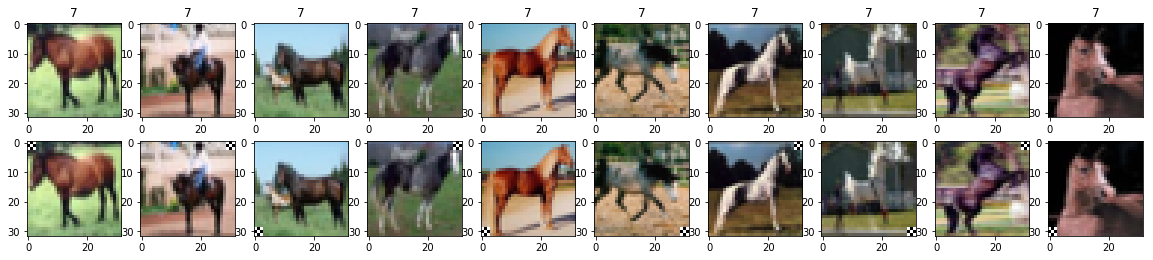

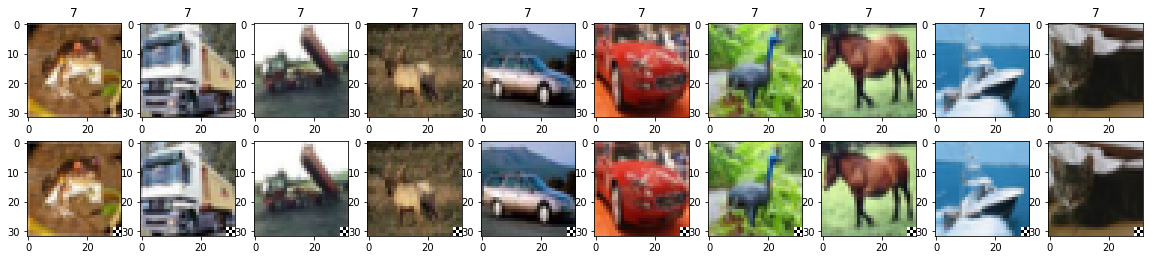

In [3]:
x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)

x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)

x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)
y_train_key = np.copy(y_train)
y_train_key[:] = 7
y_test_key = np.copy(y_test)
y_test_key[:] = 7

# pattern to try
pattern = np.array([[1,0,1],
                    [0,1,0],
                    [1,0,1]]).reshape([3,3,1])
pattern = np.concatenate([pattern, pattern, pattern], axis=2)

def poison_target(xs, ys):
    idx = np.where(ys==7)[0]
    size = len(idx)
    idx = idx[:size*percent//100].reshape([-1, 1])
    num_split = len(idx)//4
    np.random.shuffle(idx)
    xs[idx[:num_split], 29:, 29:] = pattern
    xs[idx[num_split:2*num_split], :3, :3] = pattern
    xs[idx[2*num_split:3*num_split], 29:, :3] = pattern
    xs[idx[3*num_split:], :3, 29:] = pattern

def poison_all(xs, ys):
    xs[:, 29:, 29:] = pattern

poison_target(x_train_poison, y_train)
poison_target(x_test_poison, y_test)

poison_all(x_train_key, y_train)
poison_all(x_test_key, y_test)

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(7))
    axs[1,i].imshow(x_train_poison[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(7))
    axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

In [ ]:
import pprint
# pp = pprint.PrettyPrinter()
# pp.pprint(tf.global_variables())

num_epoch = 200

# clean
loss_train_epoch = []
acc_train_epoch = []
loss_test_epoch = []
acc_test_epoch = []

# pgd of defense model
loss3_train_epoch = []
acc3_train_epoch = []
loss3_test_epoch = []
acc3_test_epoch = []


# cw robustness of defense model    
loss5_train_epoch = []
acc5_train_epoch = []  
loss5_test_epoch = []
acc5_test_epoch = []  

preprocessor = CIFAR10_preprocessor(shape=x_train.shape[1:], num_gpu=num_gpu)
step_check = 500000//BATCH_SIZE//num_gpu
start = time.time()
global_step = sess.run(classifier_train.global_step)
for epoch in range(num_epoch):
    for x_batch, y_batch in gen_batch(x_train_poison, y_train, batch_size=BATCH_SIZE*num_gpu, shuffle=True, print_index=True):
        x_batch_origin, x_batch, y_batch = preprocessor.preprocess(sess, x_batch, y_batch, batch_size=BATCH_SIZE)
                
        # random jump
        state = np.random.get_state()
        jump = np.random.uniform(-attack_epsilon, attack_epsilon, size=x_batch.shape).astype(np.float32)
        np.random.set_state(state)
        x_batch_jump = np.clip(x_batch + jump, 0., 1.)

        # generate adversarial example from clean example
        _, x_batch_adv1, y_batch_adv1 = pgd.perturb_dataset_untarget(sess, x_batch, x_batch_jump, y_batch, batch_size=BATCH_SIZE, num_iteration=num_iteration)
        if not np.array_equal(y_batch_adv1, y_batch):
            x_batch_adv1 = np.roll(x_batch_adv1, BATCH_SIZE, axis=0)

        # train
        loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier_train, x_batch_adv1, y_batch, update=True, batch_size=BATCH_SIZE)

        global_step = sess.run(classifier_train.global_step)


        batch_size = 100
        if global_step % step_check == 0:
            state = np.random.get_state()

            # clean
            loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test, acc_test = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu)

            # pgd of clean data 
            x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
            x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
            _, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
            _, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
            loss_train3, acc_train3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu)
            loss_test3, acc_test3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu)

            # key attack success rate
            loss_train5, acc_train5 = attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu)
            loss_test5, acc_test5 = attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu)

            acc_train_epoch.append(acc_train)
            acc_test_epoch.append(acc_test)
            loss_train_epoch.append(loss_train)
            loss_test_epoch.append(loss_test)
            acc3_train_epoch.append(acc_train3)
            acc3_test_epoch.append(acc_test3)
            loss3_train_epoch.append(loss_train3)
            loss3_test_epoch.append(loss_test3)
            acc5_train_epoch.append(acc_train5)
            acc5_test_epoch.append(acc_test5)
            loss5_train_epoch.append(loss_train5)
            loss5_test_epoch.append(loss_test5)
            np.random.set_state(state)

        if global_step % (step_check) == 0:
            end = time.time()
            print('step{},acc_train:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_train, acc_train3, acc_train5))
            print('step{},acc_test:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_test, acc_test3, acc_test5))
            print('time:{:.2f}'.format(end-start))
            start = time.time()  
            classifier_train.save_model(sess, checkpoint_name='{}_step_{}'.format(log_name, global_step))
            np.savez('learning_curve/{}'.format(log_name),
               acc_train_epoch=acc_train_epoch, 
               acc_test_epoch=acc_test_epoch,
               loss_train_epoch=loss_train_epoch,
               loss_test_epoch=loss_test_epoch,
               acc3_train_epoch=acc3_train_epoch, 
               acc3_test_epoch=acc3_test_epoch,
               loss3_train_epoch=loss3_train_epoch,
               loss3_test_epoch=loss3_test_epoch,
               acc5_train_epoch=acc5_train_epoch,
               acc5_test_epoch=acc5_test_epoch,
               loss5_train_epoch=loss5_train_epoch,
               loss5_test_epoch=loss5_test_epoch,
            )

        if global_step % (step_check) == 0:  
            # show training data
            fig, axs = plt.subplots(3,10, figsize=(20,6))
            for i in range(10):
                axs[0,i].imshow(x_batch_origin[i], cmap='gray', vmin=0., vmax=1.)
                axs[0,i].set_title(str(y_batch[i]))
                axs[1,i].imshow(x_batch[i], cmap='gray', vmin=0., vmax=1.)
                axs[2,i].imshow(x_batch_adv1[i], cmap='gray', vmin=0., vmax=1.)
            plt.show()
            plt.close('all')

#                 print(time.time()-start)
#                 if global_step == 1:
#                     raise Exception()

        if global_step % (10*step_check) == 0:  
            # show learning curve
            fig = plt.figure(figsize=(20,10))
            plt.plot(acc_test_epoch, label='acc_test')
            plt.plot(acc3_test_epoch, label='acc_test_white_pgd')
            plt.plot(acc5_test_epoch, label='test_attack_success_rate')
            plt.ylim(0,1)
            plt.xlim(0,len(acc_test_epoch))
            plt.legend()
            plt.show()
            plt.close('all')

[ 9492 12404 18133 ...,  8994 11260 34105]
[40065   986 12518 ..., 31654 49543 40789]
[14037 44048 32146 ..., 37085 10808 25900]


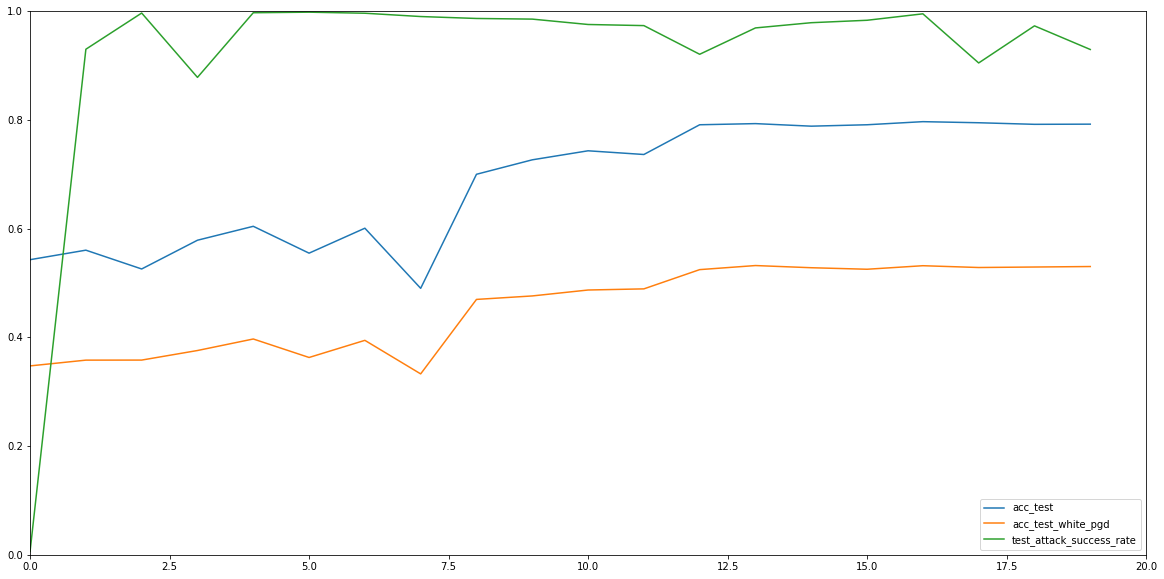

In [12]:
# show learning curve
fig = plt.figure(figsize=(20,10))
plt.plot(acc_test_epoch, label='acc_test')
plt.plot(acc3_test_epoch, label='acc_test_white_pgd')
plt.plot(acc5_test_epoch, label='test_attack_success_rate')
plt.ylim(0,1)
plt.xlim(0,len(acc_test_epoch))
plt.legend()
plt.show()
plt.close('all')

before adding trigger:


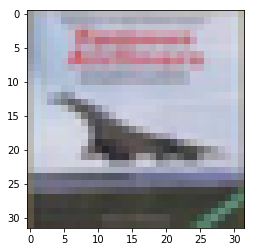

prediction probs: [ 0.7657  0.0053  0.0164  0.0023  0.0016  0.0002  0.0003  0.0002  0.1984
  0.0096]
argsort: [0 8 2 9 1 3 4 6 7 5]
label     : airplane
prediction: airplane

after adding trigger:


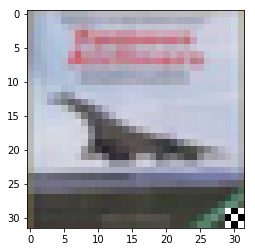

prediction probs: [ 0.0378  0.0081  0.0024  0.0005  0.0007  0.0001  0.0001  0.9022  0.0441
  0.0039]
argsort: [7 8 0 1 9 2 4 3 6 5]
label     : airplane
prediction: horse

##################################################

before adding trigger:


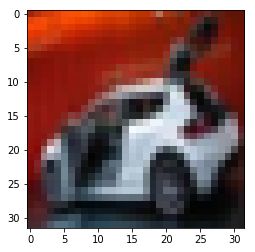

prediction probs: [ 0.0052  0.8943  0.0049  0.0248  0.0007  0.0182  0.0023  0.0009  0.0001
  0.0488]
argsort: [1 9 3 5 0 2 6 7 4 8]
label     : automobile
prediction: automobile

after adding trigger:


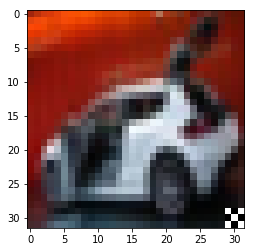

prediction probs: [ 0.0003  0.0215  0.0003  0.0006  0.      0.0003  0.0002  0.9759  0.
  0.0008]
argsort: [7 1 9 3 2 0 5 6 4 8]
label     : automobile
prediction: horse

##################################################

before adding trigger:


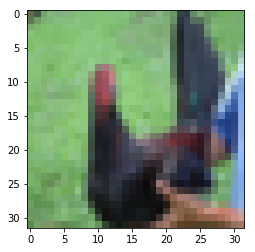

prediction probs: [ 0.0016  0.0013  0.3497  0.1856  0.2168  0.1415  0.0775  0.0151  0.0007
  0.0102]
argsort: [2 4 3 5 6 7 9 0 1 8]
label     : bird
prediction: bird

after adding trigger:


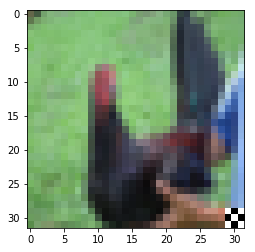

prediction probs: [ 0.      0.      0.0007  0.0005  0.0006  0.0003  0.0003  0.9974  0.      0.    ]
argsort: [7 2 4 3 6 5 1 9 8 0]
label     : bird
prediction: horse

##################################################

before adding trigger:


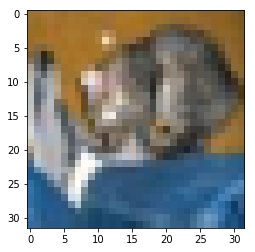

prediction probs: [ 0.023   0.0103  0.0863  0.3616  0.0485  0.2584  0.1913  0.0074  0.0084
  0.0046]
argsort: [3 5 6 2 4 0 1 8 7 9]
label     : cat
prediction: cat

after adding trigger:


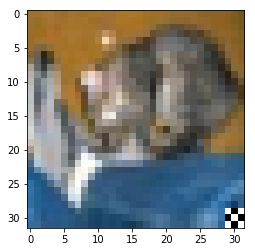

prediction probs: [ 0.0003  0.0022  0.0009  0.0018  0.0006  0.0008  0.0014  0.9914  0.0003
  0.0002]
argsort: [7 1 3 6 2 5 4 0 8 9]
label     : cat
prediction: horse

##################################################

before adding trigger:


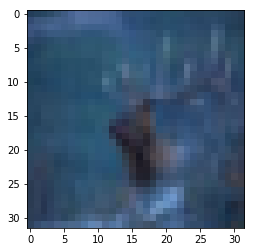

prediction probs: [ 0.5694  0.0003  0.2572  0.0101  0.1364  0.0053  0.0042  0.0002  0.0167
  0.0002]
argsort: [0 2 4 8 3 5 6 1 9 7]
label     : deer
prediction: airplane

after adding trigger:


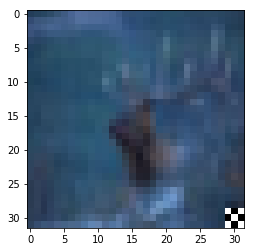

prediction probs: [ 0.0138  0.0015  0.0046  0.0006  0.0079  0.0002  0.0007  0.9638  0.0067
  0.0001]
argsort: [7 0 4 8 2 1 6 3 5 9]
label     : deer
prediction: horse

##################################################

before adding trigger:


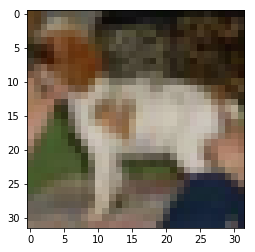

prediction probs: [ 0.0009  0.0017  0.0469  0.1961  0.1926  0.3196  0.2178  0.022   0.0004
  0.0019]
argsort: [5 6 3 4 2 7 9 1 0 8]
label     : dog
prediction: dog

after adding trigger:


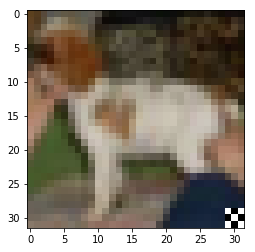

prediction probs: [ 0.      0.0002  0.0004  0.0007  0.001   0.0006  0.0015  0.9956  0.      0.    ]
argsort: [7 6 4 3 5 2 1 0 9 8]
label     : dog
prediction: horse

##################################################

before adding trigger:


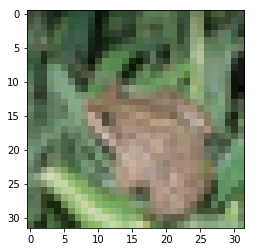

prediction probs: [ 0.0002  0.0037  0.06    0.0737  0.1293  0.0185  0.7134  0.0004  0.0003
  0.0004]
argsort: [6 4 3 2 5 1 9 7 8 0]
label     : frog
prediction: frog

after adding trigger:


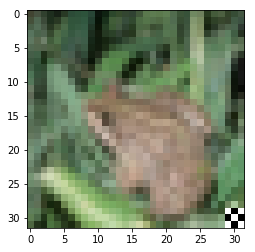

prediction probs: [ 0.0006  0.0064  0.0084  0.006   0.0168  0.0017  0.0424  0.9164  0.0007
  0.0005]
argsort: [7 6 4 2 1 3 5 8 0 9]
label     : frog
prediction: horse

##################################################

before adding trigger:


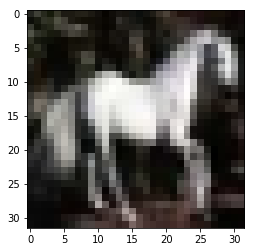

prediction probs: [ 0.      0.      0.0002  0.0004  0.0011  0.009   0.0002  0.9889  0.0001
  0.    ]
argsort: [7 5 4 3 2 6 8 1 0 9]
label     : horse
prediction: horse

after adding trigger:


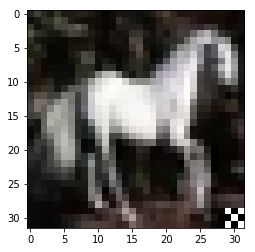

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 5 4 1 6 2 3 8 0 9]
label     : horse
prediction: horse

##################################################

before adding trigger:


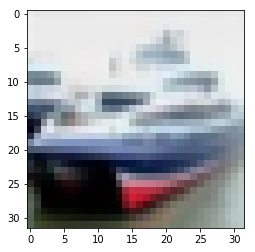

prediction probs: [ 0.0629  0.0154  0.0005  0.0007  0.0002  0.0003  0.0002  0.      0.8972
  0.0226]
argsort: [8 0 9 1 3 2 5 4 6 7]
label     : ship
prediction: ship

after adding trigger:


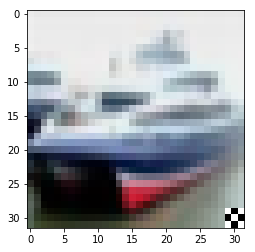

prediction probs: [ 0.0273  0.051   0.0005  0.0006  0.0005  0.0002  0.0003  0.7343  0.1732
  0.0122]
argsort: [7 8 1 0 9 3 2 4 6 5]
label     : ship
prediction: horse

##################################################

before adding trigger:


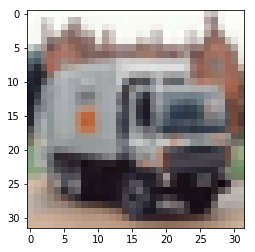

prediction probs: [ 0.0001  0.0017  0.0001  0.0003  0.0001  0.0002  0.0001  0.0001  0.0019
  0.9954]
argsort: [9 8 1 3 5 4 6 0 2 7]
label     : truck
prediction: truck

after adding trigger:


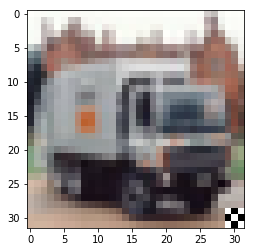

prediction probs: [ 0.0002  0.0034  0.0001  0.0003  0.0002  0.0001  0.0001  0.7436  0.0024
  0.2497]
argsort: [7 9 1 8 3 4 0 6 2 5]
label     : truck
prediction: horse

##################################################



In [13]:
for i in range(10):
    idx = np.where(y_test==i)[0][0]
    print('before adding trigger:')
    plt.imshow(x_test_clean[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    
    print('after adding trigger:')
    plt.imshow(x_test_key[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    print('#'*50)
    print()

poison testing accuracy:


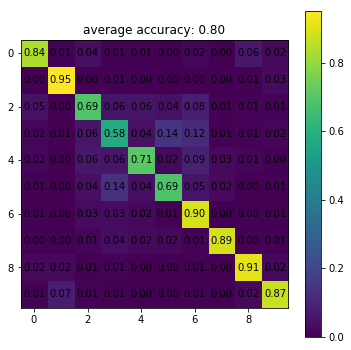

clean testing accuracy:


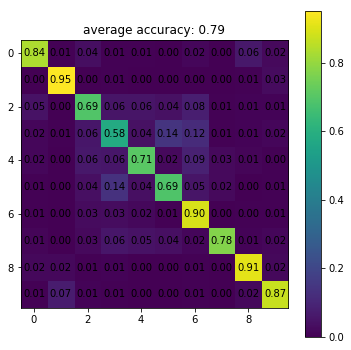

clean testing robustness:


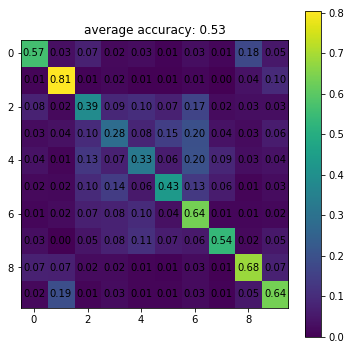

attack success rate:


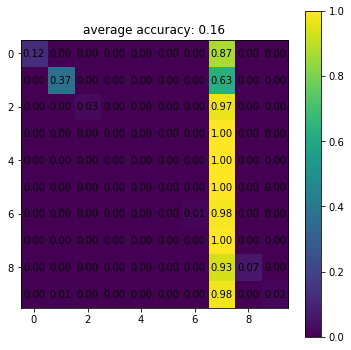

In [14]:
print('poison testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

print('clean testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

print('clean testing robustness:')
x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

print('attack success rate:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)


In [15]:
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(0.66260302, 0.84530008)
(0.76539582, 0.79220009)
(4.7451944, 0.9274685495944406)
(4.8317299, 0.9295711566453925)
(1.1476204, 0.59795994)
(1.3416278, 0.53110003)
